In [1]:
import numpy as np
import pandas as pd
import datetime

# import webdatareader_naver 
# import webdatareader_fred
from . import webdatareader_naver
from . import webdatareader_fred
__DEBUG_MODE__ = False

In [2]:
def get_db(stocknames, varnames, SL_FILEPATH = './stock_list.csv', DB_DIRPATH = './project_stock_db_csv/'): # https://www.datacamp.com/community/tutorials/finance-python-trading
    sl = pd.read_csv(SL_FILEPATH, header=0) # stock list
    sl.index = sl.pop('stockname')
    #print(sl)
    def get_data(stockname):
        filepath = DB_DIRPATH + stockname + '.csv'
        #--- read data --------------------------------------
        df = pd.read_csv(filepath)
        #--- adjust types -----------------------------------
        df.columns = sl.loc[stockname]['colname'].split()
        df.index = pd.to_datetime(df.pop('Date'))
        for varname in varnames:
            if any(df.columns == varname):
                df[varname] = pd.to_numeric(df[varname]) # make sure variable is numeric
            else:
                df[varname] = np.nan
        return df[varnames]
    datas = map(get_data, stocknames)
    return (pd.concat(datas, keys=stocknames, names=['Ticker', 'Date']))
def update_db(stocknames, varnames, SL_FILEPATH = './stock_list.csv', DB_DIRPATH = './project_stock_db_csv/', print_url = False): # https://www.datacamp.com/community/tutorials/finance-python-trading
    sl = pd.read_csv(SL_FILEPATH, header=0) # stock list
    sl.index = sl.pop('stockname')
    #print(sl)
    def update_data(stockname):
        filepath = DB_DIRPATH + stockname + '.csv'
        #--- read data --------------------------------------
        if sl.loc[stockname]['source'] == 'naver': # naver website
            url_ = sl.loc[stockname]['link']
            df = webdatareader_naver.update_data_in_db(filepath, url_, print_url = print_url)
        elif sl.loc[stockname]['source'] == 'fred': # FRED website
            ticker = sl.loc[stockname]['ticker']
            df = webdatareader_fred.update_data_in_db(filepath, ticker)
        #--- adjust types -----------------------------------
        df.columns = sl.loc[stockname]['colname'].split()
        df.index = pd.to_datetime(df.pop('Date'))
        for varname in varnames:
            if any(df.columns == varname):
                df[varname] = pd.to_numeric(df[varname]) # make sure variable is numeric
            else:
                df[varname] = np.nan
        return df[varnames]
    datas = map(update_data, stocknames)
    return (pd.concat(datas, keys=stocknames, names=['Ticker', 'Date']))
def stock_split_weight(dates, stockname, SST_FILEPATH = './stock_split_table.csv'):
    df = pd.DataFrame(index = dates, data = {'Weight':1.0}) # initialize
    tables = pd.read_csv(SST_FILEPATH, header = 0) # load stock split table
    table = tables.loc[tables['stockname'] == stockname, ] # select data of a certail stockname
    table.index = pd.RangeIndex(len(table.index)) # reset the index: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame
    print(table)
    for irow in range(table.shape[0]):
        Date = table.loc[irow, 'Date']
        Weight = table.loc[irow, 'Weight']
        df.loc[df.index <= Date, 'Weight'] *= Weight
    return df

  stockname        Date    Weight  \
0     Naver   7/13/2006  2.944444   
1     Naver   8/28/2013  0.684900   
2     Naver  10/11/2018  5.000000   

                                                link  
0                                                NaN  
1  https://kin.naver.com/qna/detail.nhn?d1id=4&di...  
2                                                NaN  


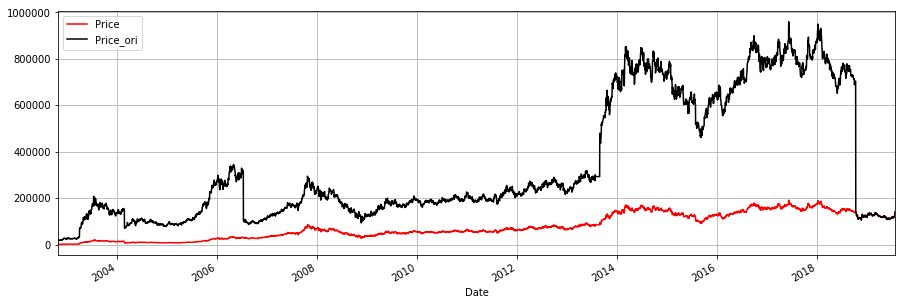

In [7]:
SL_FILEPATH = 'C:/Users/bomsoo/bomsoo1/project/projects/_stock_currency_prediction/stock_list.csv' # stock list file path
DB_DIRPATH = 'C:/Users/bomsoo/bomsoo1/project/projects/_stock_currency_prediction/project_stock_db_csv/' # database directory path
SST_FILEPATH = 'C:/Users/bomsoo/bomsoo1/project/projects/_stock_currency_prediction/stock_split_table.csv'

if __DEBUG_MODE__ and False:
#     df = update_db(
    df = get_db(
        ['Naver', 'SamsungElectronics', 'KRW', 'KOSPI', 'Gold',
         'unemployment_US', 'nonfarm_payroll_employment_US', 'Federal_Funds_Target_Rate', 'Foreign_Exchange_Rate_Korea_US', 
         'Foreign_Exchange_Rate_Canada_US', 'Consumer_Price_Index_for_All_Urban_Consumers_All_Items']
        , ['Price', 'Volume'], SL_FILEPATH, DB_DIRPATH)
    #----------------------------------------------------------------------
    price_df = df.reset_index().pivot('Date','Ticker','Price')
    price_df['unemployment_US'].dropna().plot(grid = True, figsize=(15,8))
    price_df['KRW'].dropna().plot(grid = True, secondary_y=True)

if __DEBUG_MODE__ and False:
    import matplotlib.pyplot as plt
    %matplotlib inline
    
#     df = update_db(['Naver', 'SamsungElectronics', 'KRW', 'KOSPI', 'Gold'], ['Price', 'Volume'], SL_FILEPATH, DB_DIRPATH)
    df = get_db(['Naver', 'SamsungElectronics', 'KRW', 'KOSPI', 'Gold'], ['Price', 'Volume'], SL_FILEPATH, DB_DIRPATH)
    #----------------------------------------------------------------------
    price_df = df.reset_index().pivot('Date','Ticker','Price')
    pct_change_price = price_df.pct_change()
    pct_change_price.hist(bins=400, sharex=True, figsize=(12,5))
    plt.show()
    print(pct_change_price.describe())
    #----------------------------------------------------------------------
    pd.scatter_matrix(pct_change_price, diagonal='kde', alpha=0.1,figsize=(12,12))
    plt.show()
    #--- moving average -------------------------------------------------------------------
    naver = df.loc[['Naver'],['Price']]
    naver['40'] = naver['Price'].rolling(window=40).mean()
    naver['252'] = naver['Price'].rolling(window=252).mean()
    print(naver.head())
    naver.plot()
    plt.show()
    #----------------------------------------------------------------------
    cum_daily_return = (1 + pct_change_price).cumprod()
    cum_daily_return.plot(figsize=(12,8))
    plt.show()
    cum_daily_return.tail()

    #mon_return = pct_change_price.resample('M').apply(lambda x: x[-1])
    mon_return = pct_change_price.resample('M').mean()
    mon_return.tail()
    
if __DEBUG_MODE__ and False:
    tickername = 'Naver'
    df = get_db([tickername], ['Price', 'Volume'], SL_FILEPATH, DB_DIRPATH).loc[tickername] # strip out the tickername in the row index
    df['Price_ori'] = df['Price'] # back-up
    df['Weight'] = stock_split_weight(df.index, tickername, SST_FILEPATH)
    df['Price'] = df['Price'] / df['Weight'] # correction
    df[['Price','Price_ori']].plot(figsize=(15,5), grid=True, color=['r','k'])
